<h1 style="font-size:50px;">Recommendation-System-for-Book-Crossing-Data</h1>
<p></p>
<h2 style="font-size:30pt; color:blue;"><b>Data Cleaning Notebook</b></h2>

<h2 style="font-size:25pt;"> Introduction</h2>

<p style="font-size:15pt;"> In this notebook, by using some techniques we will perform Data Cleansing and some Exploratory Analysis on the <a href="http://www2.informatik.uni-freiburg.de/~cziegler/BX/">Book-Crossing Dataset</a> collected by Cai-Nicolas Ziegler. The reason is to prepare the data in a usable format and also, to gain some intuition about the data. By this, we can know the best model to use in building the recommender system to provide book-crossing recommendations. </p>

 
<p></p>
<p style="color:blue;font-size:15pt;">The dataset consists of three files.</p>
 <ul style="font-size:20px">
  <li><em><b>BX_Users.csv</b></em> containing data from 278858 users (User Id, Location, Age).</li>
  <li><em><b>BX_Books.csv</b></em> has information for 271379 books including Title, Author, Year of Publication, Publisher and Cover images.</li>
  <li><em><b>BX_Book_Ratings.csv.</b></em> holding 1149780 ratings from the users.</li>
</ul>
<hr>
 

In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gensim 
import tqdm   #to visualize loops' progress
%matplotlib inline

C:\Users\user1\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


<p style="font-size:15pt">I downloaded the data in csv format, so we are going to use <i>pandas.read_csv()</i> to create three DataFrames.</p> 

In [2]:
## Import Data from csv
# read Users
u_cols = ['user_id', 'location', 'age']
users = pd.read_csv('Data\datasets\BX_Users.csv', sep=';', names=u_cols, encoding='latin-1',low_memory=False)

# read Books/items
i_cols = ['isbn', 'book_title' ,'book_author','year_of_publication', 'publisher', 'img_s', 'img_m', 'img_l']
items = pd.read_csv('Data\datasets\BX_Books.csv', sep=';', names=i_cols, encoding='latin-1',low_memory=False)

# read Ratings
r_cols = ['user_id', 'isbn', 'rating']
ratings = pd.read_csv('Data\datasets\BX_Book_Ratings.csv', sep=';', names=r_cols, encoding='latin-1',low_memory=False)

<p></p>
<p style="font-size:15pt">Now let's print the 3 first elements of each dataframe we created</p>

In [3]:
print('                                  Users')
print(users.head(3))
print("\n")
print('                                  Items')
print(items.head(3))
print("\n")
print('                                  Ratings')
print(ratings.head(3))

                                  Users
   user_id                   location  age
0  User-ID                   Location  Age
1        1         nyc, new york, usa  NaN
2        2  stockton, california, usa   18


                                  Items
         isbn           book_title           book_author  year_of_publication  \
0        ISBN           Book-Title           Book-Author  Year-Of-Publication   
1  0195153448  Classical Mythology    Mark P. O. Morford                 2002   
2  0002005018         Clara Callan  Richard Bruce Wright                 2001   

                 publisher                                              img_s  \
0                Publisher                                        Image-URL-S   
1  Oxford University Press  http://images.amazon.com/images/P/0195153448.0...   
2    HarperFlamingo Canada  http://images.amazon.com/images/P/0002005018.0...   

                                               img_m  \
0                                       

<p></p><p style="font-size:15pt">From the result above, we can see that the first line of each Dataframe (Df) contains the column names. We shall remove them and then reset the index of the Dataframes. <br><br>Moreso, Df <b>"Items"</b> has 3 columns of image URLs, we will get rid of them because we are not going to need them.</p>


In [4]:
users = users.loc[1:]
users.reset_index(drop=True, inplace=True)

items = items.loc[1:]
items.reset_index(drop=True, inplace=True)
items.drop(['img_s','img_m','img_l'], axis=1, inplace=True)

ratings = ratings.loc[1:]
ratings.reset_index(drop=True, inplace=True)

print('                                  Users')
print(users.head(4))
print("\n")
print('                                  Items')
print(items.head(4))
print("\n")
print('                                  Ratings')
print(ratings.head(4))

                                  Users
  user_id                         location  age
0       1               nyc, new york, usa  NaN
1       2        stockton, california, usa   18
2       3  moscow, yukon territory, russia  NaN
3       4        porto, v.n.gaia, portugal   17


                                  Items
         isbn                                         book_title  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                               Decision in Normandy   
3  0374157065  Flu: The Story of the Great Influenza Pandemic...   

            book_author year_of_publication                publisher  
0    Mark P. O. Morford                2002  Oxford University Press  
1  Richard Bruce Wright                2001    HarperFlamingo Canada  
2          Carlo D'Este                1991          HarperPerennial  
3      Gina Bari Kolata                1999     Farra

<p></p><p style="font-size:15pt">Let's now use <em>DataFrame.describe()</em> function to see whatelse we can find about our data</p>

In [5]:
print(users.describe(),"\n"*2)
print(items.describe(),"\n"*2)
print(ratings.describe())

       user_id                         location     age
count   278858                           278858  168096
unique  278858                            57339     165
top      51322  london, england, united kingdom      24
freq         1                             2506    5687 


              isbn      book_title      book_author year_of_publication  \
count       271379          271379           271378              271379   
unique      271379          242154           102042                 137   
top     0486298973  Selected Poems  Agatha Christie                2002   
freq             1              27              632               17627   

        publisher  
count      271377  
unique      16824  
top     Harlequin  
freq         7535   


        user_id        isbn   rating
count   1149780     1149780  1149780
unique   105283      340556       11
top       11676  0971880107        0
freq      13602        2502   716109


<p style="font-size:15pt">From the above, we can see that
<ul style="font-size:12pt">
<li>Age is not numerical. We'll have to convert it to <em>int</em></li>
<li>Year of publication is also not numerical. We'll have to convert it to <em>int</em> as well</li>
<li>I also guess that there are some duplicate books in there.</li>
<li>We have <em>ratings</em> for 340556 different book titles. This is more than the actual books in "items" Df</li>
<li>The <em>ratings</em> come from 105283 different <em>users</em></li> 
</ul>

<p style="font-size:12pt"> </p>
<hr>

<h2 style="font-size:25pt;"> <b>Users DataFrame</b></h2>

<p style="font-size:15pt;">Now, we take a closer look at the <em>"users"</em> Df.</p>
<p style="font-size:15pt"> Let's convert <em>users.user_id</em> to 'int' (we'll need in future) and <em>users.age</em> to 'float' ('int' will also be a good solution but since there are numerous NaN values, we have to go with 'float' first.) After conversion, we call <em>df.describe()</em> again.</p>

In [6]:
users.age = users.age.astype(float)
users.user_id = users.user_id.astype(int)
users.describe(include=[object, int, float])

,user_id,location,age
count,278858.00000,278858,168096.000000
unique,NaN,57339,NaN
top,NaN,"london, england, united kingdom",NaN
freq,NaN,2506,NaN
mean,139429.50000,NaN,34.751434
std,80499.51502,NaN,14.428097
min,1.00000,NaN,0.000000
25%,69715.25000,NaN,24.000000
50%,139429.50000,NaN,32.000000
75%,209143.75000,NaN,44.000000


<br></br><h2 style="font-size:20pt;"> users.age</h2>

<p style="font-size:15pt"> Taking a closer look at "users.age" Series,</p> 
<p style="font-size:15pt"> We can see from the above that there are 110762 missing values in <em>users.age</em>. Also, it has a mean value around 34.75 and a deviation of 14.43.</p> 
<p style="font-size:15pt"> Next, we shall plot users.age histogram and then investigate how many NaN values there are in the Series and how many values are "not so logical" (> 5 or < 99).</p>

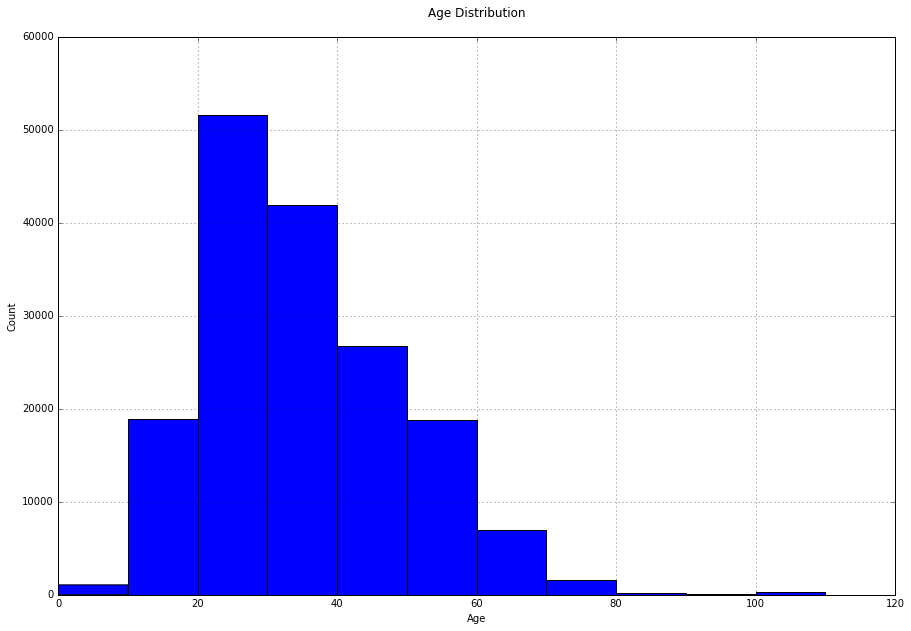

In [7]:
users.age.hist(bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110], figsize=(15,10))
plt.title('Age Distribution\n')
plt.xlabel('Age')
plt.ylabel('Count')
plt.savefig('Data/images/system1.jpg', bbox_inches='tight')
plt.show()

In [8]:
print("NaN values in age:", users.age[users.age.isna()].count())
print("Users with 5 > age & age > 99 :",users.loc[(users.age>99) | (users.age<5),'age'].count())
users.loc[(users.age>99) | (users.age<5),'age'] = np.nan

NaN values in age: 0
Users with 5 > age & age > 99 : 1255


<p style="font-size:15pt"><b>Wow</b>, 110762 missing values in <em>users.age</em> and another 1255 users have <i>age</i> values that I think are invalid. <br></br>Since we really don't like NaN values in datasets we will replace them with a value. This value can be the mean age of the users that registered their age or it can be based on some values of the dataset. For example, we can use the location of the user and use the average age of the population of this location, or we can use the average age of the population using PCs on that location since this dataset was collected from a website. We can even use an ML algorithm to determine the missing values. The easiest way  would be to use the mean.</p>

In [9]:
users.age.fillna(users.age.mean()).describe()

count    278858.000000
mean         34.743900
std          10.540292
min           5.000000
25%          29.000000
50%          34.743900
75%          35.000000
max          99.000000
Name: age, dtype: float64

<p style="font-size:15pt">But if we do the above, we would notice that the deviation changed a lot, 3.1 units. And since we don't want to create a huge group of 112017 users with the same age, we are going to try something different.</p>

In [10]:
# create a normal distribution pd.Series to fill Nan values with
temp_age_series = pd.Series(np.random.normal(loc=users.age.mean(), scale=users.age.std(), size=users.user_id[users.age.isna()].count()))
print("Statistics of values in \'users.age\'\n",users.age.describe(),"\n")
print("Statistics of values we are going to use to fill NaN \n",temp_age_series.describe(),"\n")
print("Negative values in \'temp_age_seires\':", temp_age_series[temp_age_series<0].count(),"\n")
print("As we can see the destribution doesnt change a lot. There are some negative values thought (around 600 of them).\n")

# take the abs value of temp_age_series
pos_age_series=np.abs(temp_age_series)

# sort users Df so as NaN values in age to be first and reset index to match with index of pos_age_series. Then use fillna()
users = users.sort_values('age',na_position='first').reset_index(drop=True)
users.age.fillna(pos_age_series, inplace = True)  

# replace values < 5 with the mean(). Round values and convert them to int. 
users.loc[users.age<5, 'age'] = users.age.mean()
users.age = users.age.round().astype(int)
#Sort users based on user_id so as to be the same as before
users = users.sort_values('user_id').reset_index(drop=True)
print(users.age.describe(),"\n")
users.head()

Statistics of values in 'users.age'
 count    166841.000000
mean         34.743900
std          13.626783
min           5.000000
25%          24.000000
50%          32.000000
75%          44.000000
max          99.000000
Name: age, dtype: float64 

Statistics of values we are going to use to fill NaN 
 count    112017.000000
mean         34.765691
std          13.588075
min         -20.755140
25%          25.641087
50%          34.743869
75%          43.904104
max          93.064243
dtype: float64 

Negative values in 'temp_age_seires': 577 

As we can see the destribution doesnt change a lot. There are some negative values thought (around 600 of them).

count    278858.000000
mean         34.933393
std          13.372016
min           5.000000
25%          25.000000
50%          33.000000
75%          44.000000
max          99.000000
Name: age, dtype: float64 



,user_id,location,age
0,1,"nyc, new york, usa",27
1,2,"stockton, california, usa",18
2,3,"moscow, yukon territory, russia",46
3,4,"porto, v.n.gaia, portugal",17
4,5,"farnborough, hants, united kingdom",35


<br><p style="font-size:15pt">Finally, we have to decide if we are going to let users.age as a numerical (quantitative) data or if we should change it to categorical (qualitative). If we choose "numerical" we add a continuity to the data. It might, for example, show that people read more books or rate them lower as they age. On the other hand, if we choose to change it to categorical then it will be better to talk about "age group" and we will treat the users of each group as a class.<br><br>I am going to leave it as it is for now (numerical). In case you like to make it categorical all you have to do is to change each users age with a group (e.g {if (users.age>5)&(users.age< 15) then '5-15'} and so on ) and then use pd.get_dummies() to get the one-hot encoding of it.</p>  <p style="font-size:15pt"> Thanks to PascPeli for this.</p>

<br></br><h2 style="font-size:20pt;"> users.location</h2>
<p style="font-size:15pt">Continuing on with the <i>"users.location"</i> Series. It is formatted as a long string containing three comma-separated instances

In [11]:
users.location.head()

0                    nyc, new york, usa
1             stockton, california, usa
2       moscow, yukon territory, russia
3             porto, v.n.gaia, portugal
4    farnborough, hants, united kingdom
Name: location, dtype: object

<br></br><p style="font-size:15pt">I believe that it would be more insightful to separate those strings. So, I suggest we should split the <i>"users.location"</i> in three different columns: <i>"city"</i>, <i>"state"</i> and <i>"country"</i> </p>

In [12]:
location_split=users.location.str.split(', ', n=2, expand=True)
location_split.columns=['city', 'state', 'country']
location_split.describe(include=[object])

,city,state,country
count,278858,278857,274281
unique,33076,6663,1130
top,london,california,usa
freq,4105,19839,139421


<p style="font-size:15pt;">Having done that, we can easily detect invalid or NaN values. There are users with <em>"state" == ','</em>  and <em>"country"== None</em> . We are going to replace those values with 'other'.<br>There are also some users with ' ', '\\n/a\\"', 'n.a' or '*' as a "state" value, we'll replace those with 'n/a'</p>

In [13]:
location_split.loc[location_split.state==',', ['state', 'country']] = 'other'
location_split.loc[location_split.country==',', ['country']] = 'other'
location_split.loc[(location_split.state=='\\n/a\\"') | (location_split.state=='') | (location_split.state=='*') | (location_split.state=='n.a'), ['state']] = 'n/a'
location_split.state.fillna('other', inplace=True)
location_split.fillna('n/a', inplace=True)

<p style="font-size:15pt;">All those different values would increase the dimensionality tremendously if we were to use One-Hot encoding. In an attempt to tackle this we can start replacing not so frequent values with 'other'. But that will lead us to lose quite a lot of data (depending on the "keep threshold"). And even with that, the resulting One-Hot encoding columns will be equal to the [No of unique strings in "location_split" = 40864 (after the previous operations)].
<br><br>Instead, I suggest we transform all those locations to vectors (Word embeddings). To do this, we will train a <a href="https://en.wikipedia.org/wiki/Word2vec">Word2Vec model</a> and we will use the location values as input. In order to do this we will use the Gensim library implementation of the <a href="https://radimrehurek.com/gensim/models/word2vec.html">model</a>. In this way, we will be able to replace the three columns with <b>3*n</b> new columns, where <b>n</b> is the size of the Word2Vec model Neural Network.
<br>This might not be the conventional usage of a word embedding model but good for keeping the dimensions low, it also helps in case we want to classify the users based on location.</p> <p style="font-size:15pt"> Thanks to PascPeli for this.</p> 


In [14]:
temp_location_df = pd.concat([location_split.city, location_split.state,  location_split.country, location_split.state, location_split.city, location_split.country, location_split.city], axis=1)
location_list = temp_location_df.fillna('n/a').values.tolist()

<p style="font-size:15pt;">The selected parameters of the model work well, though you can change it.</p>

In [15]:
n = 10
model = gensim.models.Word2Vec(location_list, size= n, window=3, min_count=1, workers=4)
print ('UK is to Milton Keynes what Greece is to : ')
model.wv.most_similar(positive=['greece','united kingdom'], negative=['milton keynes'], topn=20)

UK is to Milton Keynes what Greece is to : 


[('komotini', 0.9673100113868713),
 ('kavala', 0.9472814798355103),
 ('chania', 0.9459115266799927),
 ('weiden', 0.9435837864875793),
 ('mietingen', 0.9396860599517822),
 ('timbaki', 0.9364990592002869),
 ('piraeus', 0.9339441061019897),
 ('mykonos', 0.9286924600601196),
 ('borgholzhausen', 0.9260940551757812),
 ('coswig', 0.9226324558258057),
 ('sangudo', 0.9199614524841309),
 ('eislingen/fils', 0.9138667583465576),
 ('heraklion', 0.9112120866775513),
 ('patras', 0.9094954133033752),
 ('county', 0.9093642830848694),
 ('crete', 0.9092668294906616),
 ('attiki', 0.9090889096260071),
 ('pulheim-brauweiler', 0.9061198234558105),
 ('achaia', 0.8988022804260254),
 ('feldafing', 0.8940157890319824)]

<p style="font-size:13pt;">With most of them being either cities or states of Greece.</p>
<p style="font-size:15pt;">The cell below constructs the 'location_vec' Df where "city, "state" and "country" are represented with their respective vectors calculated with Word2Vec model.</p>
<p style="font-size:13pt; color:blue">The operations that follow may require a substantial amount of time. If you choose to skip it, it will not affect the rest of the notebook.</p>
<p style="font-size:15pt"> Thanks to PascPeli for the code below.</p> 

In [16]:
rightchoice=['1','2']
choice = input("Choose \'1\' to skip this step or \'2\' to construct the \'location_vec\' DataFrame.")
while choice not in rightchoice:
    choice = input("Wrong input. \n Insert a number. Either 1 or 2")
if choice=='1':
    print ('Skipping operations')
else:
    zipp = list(zip(model.wv.index2word, model.wv.syn0))
    vectors = np.zeros((location_split.shape[0],3*n))
    for i in tqdm.tqdm_notebook(range(location_split.shape[0])):
        vectors[i, 0:20] = [j[1][0] for j in zipp if j[0] == location_split.loc[i, 'city']]
        vectors[i,20:40] = [j[1][0] for j in zipp if j[0] == location_split.loc[i, 'state']]
        vectors[i,40:60] = [j[1][0] for j in zipp if j[0] == location_split.loc[i, 'country']]
    col=[]
    for i in range(20):
        col.append('city_'+ str(i))
    for i in range(20):
        col.append('state_'+ str(i))
    for i in range(20):
        col.append('country_'+ str(i))

    location_vec = pd.DataFrame(vectors, columns = col)

Choose '1' to skip this step or '2' to construct the 'location_vec' DataFrame.1
Skipping operations


<br><h2 style="font-size:20pt;"> users_new</h2>

<p style="font-size:15pt;">Finally, we can create a new DataFrame named "users_new". This "users_new" will contain</p> 
<ul style="font-size:13pt;">
the "users.id", <br>the "location_vec" if the Df exist or the "location_spit" otherwise <br>and the "users.age".
</ul>
<p style="font-size:12pt; color:blue">Replace "users.age" with pd.get_dummies(users.age) if you chose age to be categorical.</p>

In [17]:
if 'location_vec' in globals():
    users_new = pd.concat([users.user_id, location_vec , users.age], axis=1)    
else:
    users_new = pd.concat([users.user_id, location_split , users.age], axis=1)
users_new.head()

,user_id,city,state,country,age
0,1,nyc,new york,usa,27
1,2,stockton,california,usa,18
2,3,moscow,yukon territory,russia,46
3,4,porto,v.n.gaia,portugal,17
4,5,farnborough,hants,united kingdom,35


<p style="font-size:15pt;">We could investigate one last thing in "users" before we move on to the next dataframe; and that is the number of users that have rated <b>at least one item</b>. So...</p>

In [18]:
print(users_new[users_new.user_id.isin(ratings.user_id)].user_id.count(),'users have submited at least one review')
print(users_new[~users_new.user_id.isin(ratings.user_id)].user_id.count(), 'users have not submited any review')

105283 users have submited at least one review
173575 users have not submited any review


<br><h2 style="font-size:25pt;"> <b>Items DataFrame</b></h2>

<p style="font-size:15pt;">As mentioned before, <em>"items"</em> Df consists of the books' <em>isbn, title, author, year of publication and publisher</em>.<br><br> It would be a good start to convert the values in "year_of_publication" to int. When we try that we get the following error.
<p style="font-size:15pt;"><em style="color:red">ValueError: </em><em style="color:blue">invalid literal for int() with base 10: 'John Peterman'</em><p></p>
<p style="font-size:15pt;">That indicates that some values got mixed up. I opened the csv in a text editor and corrected the few entries that were messed up and stored the file as "BX_Books_correct.csv". It turns out that most of the errors were caused by <em style="color:green">"&"</em> character been written as <em style="color:red">"&</em><em style="font-size:4px;"> </em><em style="color:red">amp;"</em> with the semicolon causing a string split at the wrong position of the csv file. There were also some other entries that contained semicolons at the "book_title" or the "book_author".</p> <p style="font-size:15pt"> Kudos to PascPeli for this idea.</p>

<p style="font-size:15pt;">So, let's import the corrected csv.</p>


In [19]:
items = pd.read_csv('Data\datasets\BX_Books_correct.csv', sep=';', names=i_cols, encoding='latin-1',low_memory=False)
items = items.loc[1:]
items.reset_index(drop=True, inplace=True)
items.drop(['img_s','img_m','img_l'], axis=1, inplace=True)
items.year_of_publication = items.year_of_publication.astype(int)
items.describe(include =[object, int])
items.head()

,isbn,book_title,book_author,year_of_publication,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company


<p style="font-size:15pt;">From the above we can see that : 
<ul style="font-size:12pt;">
<li> The "isbn" column has only unique values, as expected.</li>
<li> There are duplicates in the "book_titles". Some might be indeed duplicate entries but some are just books with the same title. </li>
<li>Agatha Christie is the most frequently appearing author. </li>
<li>The min value in "year_of publication" is <b>0</b> and the max <b>2050 (?!?)</b>.</li>
<li>There is one missing value in the "book_author" column and two in the "publisher".</li>
</ul>
</p>

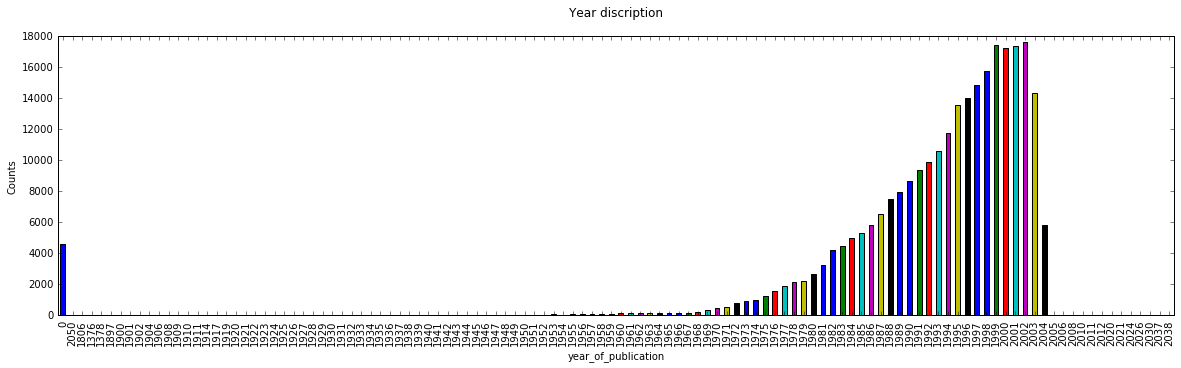

In [20]:
items.year_of_publication.value_counts(sort=False).plot(kind='bar',figsize=(20,5))
plt.title('Year discription\n')
plt.xlabel('year_of_publication')
plt.ylabel('Counts')
plt.savefig('Data/images/system2.jpg', bbox_inches='tight')
plt.show()

<br><h2 style="font-size:20pt;"> Replace NaN and incorrect "year_of_publication" values</h2>
<p style="font-size:15pt;">Starting with replacing the missing values, since the number of them is so small. I would prefer to replace them with the correct values rather than with "other" for example. Those items are:</p>

In [21]:
print ("Items with NaN values in \"book_author\": \n", items.isbn[items.book_author.isna()],"\n")
print ("Items values in \"publisher\": \n", items.isbn[items.publisher.isna()])

Items with NaN values in "book_author": 
 187700    9627982032
Name: isbn, dtype: object 

Items values in "publisher": 
 128896    193169656X
129043    1931696993
Name: isbn, dtype: object


<p style="font-size:15pt;">A search for the item missing the "book_author" yields an item with no author. The search for the books with no publishers shows that they both have the same publisher. So the following lines of code fill NaN values with the correct ones.</p>

In [22]:
items.loc[187701,'book_author'] = "n/a"
items.loc[[128897, 129044],'publisher'] = "NovelBooks, Inc"

<p style="font-size:15pt;">Next, we should search for the incorrect "year_of_publication" values. This dataset was created in 2004 so it would be logical to assume that values greater than that should be replaced. But then I took a closer look at some items and they were published in 2005 so, I guess, the dataset was updated. I am going to use 2010 as an upper limit and investigate further for the lower limit.</p>

In [23]:
print('Items with (year_of_publication > 2010):', items.year_of_publication[items.year_of_publication>2010].count(),'\n')
print('value_counts of items with (year_of_publication < 1500): \n', items.year_of_publication[items.year_of_publication<1500].value_counts())

Items with (year_of_publication > 2010): 20 

value_counts of items with (year_of_publication < 1500): 
 0       4619
1378       1
1376       1
Name: year_of_publication, dtype: int64


In [24]:
items.loc[(items.year_of_publication>2010)|(items.year_of_publication<1000),'year_of_publication'] = np.nan
print(items.describe(),'\n')
print(items.year_of_publication.fillna(round(items.year_of_publication.mean())).describe())

       year_of_publication
count        266740.000000
mean           1993.687062
std               8.320673
min            1376.000000
25%            1989.000000
50%            1996.000000
75%            2000.000000
max            2010.000000 

count    271379.000000
mean       1993.692412
std           8.249348
min        1376.000000
25%        1989.000000
50%        1995.000000
75%        2000.000000
max        2010.000000
Name: year_of_publication, dtype: float64


<p style="font-size:15pt;">The mean and the std don't change that much so I will use the mean as a replacement. If you want, you can try the method used in <em>"users.age"</em> or something else...</p>

In [25]:
items.year_of_publication.fillna(round(items.year_of_publication.mean()),inplace=True)
items.year_of_publication = items.year_of_publication.astype(int)

<br><h2 style="font-size:20pt;"> Dealing with duplicate entries</h2>
<p style="font-size:15pt;">Moving on to duplicate detection of items entries, we saw before that there are 29225 duplicate book titles. That's counting only the ones that are exactly the same. Then again there might be some books with the exact same title but they might not be written by the same author, meaning <b>not</b> the same book (except if the author's name is written a bit differently so...). Now let's investigate how many items have the same title and author. They will be duplicate entries with great probability.</p>

In [26]:
print(items[(items.duplicated(['book_title', 'book_author'], keep=False))].describe(include=[object]),'\n'*2)
print(items[(items.duplicated(['book_title', 'book_author'], keep='first'))].describe(include=[object]),'\n'*2)
print(items[(items.duplicated(['book_title', 'book_author']))].book_author.value_counts().head())

              isbn    book_title      book_author         publisher
count        35921         35921            35921             35921
unique       35921         15376             7694              2505
top     0140430075  Little Women  Agatha Christie  Ballantine Books
freq             1            21              259              1095 


              isbn    book_title   book_author         publisher
count        20175         20175         20175             20175
unique       20175         15376          7694              2019
top     0140430075  Little Women  Stephen King  Ballantine Books
freq             1            20           192               590 


Stephen King           192
Agatha Christie        156
Dick Francis            90
Jane Austen             72
William Shakespeare     71
Name: book_author, dtype: int64


<p style="font-size:15pt;">So, there are 35921 books with the same title and author (possibly different editions). If our goal is to build a <b>Book Recommender</b> then we care much more about the title rather than the specific editions. At least that's how I see it. That's why I believe we should delete all duplicates. From those 35921, if we keep the first occurrence, there will be 20175 redundant books. <br>But we must be <b>careful</b>! We have to transfer all the ratings of the deleted titles to the titles we will keep. We will do this later when we will process the <em>"ratings" Df</em>. For now let's create an <em>"items_wo_duplicates" Df</em>.</p>

In [27]:
items_wo_duplicates = items.drop_duplicates(['book_title', 'book_author'])
items_wo_duplicates.describe(include=[object,int])

,isbn,book_title,book_author,year_of_publication,publisher
count,251204,251204,251203,251204.000000,251202
unique,251204,242154,102029,NaN,16617
top,0486298973,Selected Poems,William Shakespeare,NaN,Harlequin
freq,1,25,496,NaN,7508
mean,NaN,NaN,NaN,1993.705817,NaN
std,NaN,NaN,NaN,8.245138,NaN
min,NaN,NaN,NaN,1376.000000,NaN
25%,NaN,NaN,NaN,1989.000000,NaN
50%,NaN,NaN,NaN,1995.000000,NaN
75%,NaN,NaN,NaN,2000.000000,NaN


<p style="font-size:15pt;">The new "items" Df now has 9050 duplicate books but none of them is also from the same author. Agatha Christie is no more the most frequent author but William Shakespeare took her place.</p>

<br><h2 style="font-size:25pt;"><b>Ratings DataFrame</b></h2>

<p style="font-size:15pt;">The last DataFrame is <em>"ratings"</em> and consists of three columns. These are <em>"user_id", "isbn" and "rating".</em> <br>The ratings of each user are either <b>explicit</b> (1-10) meaning the user rated the item, or <b>implicit</b> (0) meaning the result of observed behavior.<br>First things first. As we saw earlier there are ratings which do not correspont to items in our dataset. We don't need those since we cannot recommend those items. We will create a "ratings_new" Df only with the ratings for the books in our dataset. And then we will convert the "ratings.rating" to 'int'. </p>

In [28]:
ratings_new = ratings[ratings.isbn.isin(items.isbn)]
ratings_new.describe()

,user_id,isbn,rating
count,1031175,1031175,1031175
unique,92107,270170,11
top,11676,0971880107,0
freq,11144,2502,647323


In [29]:
# convert the "ratings.rating" to 'int
ratings_new.loc[:,'rating'] = ratings_new.rating.astype(int)
print(ratings_new.rating.value_counts(sort=False))
ratings_new.describe(include=[object,int])

C:\Users\user1\Anaconda3\lib\site-packages\pandas\core\indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


0     647323
1       1481
2       2375
3       5118
4       7617
5      45355
6      31689
7      66404
8      91806
9      60780
10     71227
Name: rating, dtype: int64


,user_id,isbn,rating
count,1031175,1031175,1.031175e+06
unique,92107,270170,NaN
top,11676,0971880107,NaN
freq,11144,2502,NaN
mean,NaN,NaN,2.839022e+00
std,NaN,NaN,3.854149e+00
min,NaN,NaN,0.000000e+00
25%,NaN,NaN,0.000000e+00
50%,NaN,NaN,0.000000e+00
75%,NaN,NaN,7.000000e+00


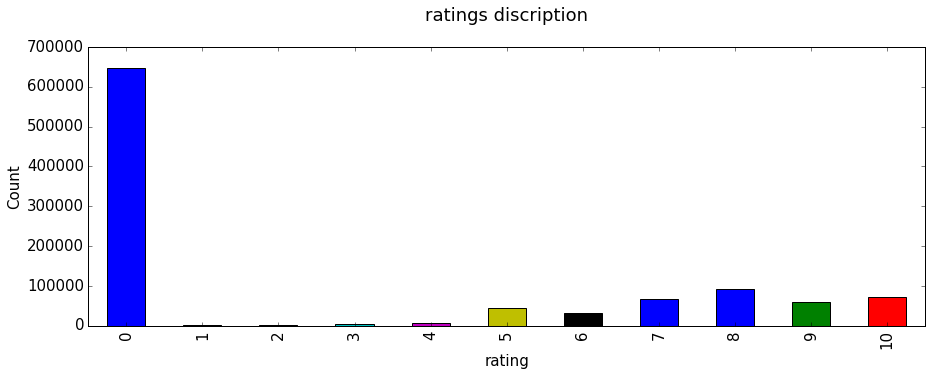

In [30]:
plt.rc("font", size=15)
ratings_new.rating.value_counts(sort=False).plot(kind='bar', figsize=(15,5))
plt.title('ratings discription\n')
plt.xlabel('rating')
plt.ylabel('Count')
plt.savefig('Data/images/system3.jpg', bbox_inches='tight')
plt.show()

<p style="font-size:15pt;">One thing that caught an attention when looked at the "ratings" description is that more than 50% of all ratings are implicit.
<br><br>Before we go further, we will have to transfer all the ratings of duplicated titles and then create a "ratings_wo_duplicates" Df. To do this, we can choose <b>either</b> to import the '*.csv' file I have created <b>or</b> to reconstruct. <p style="font-size:15pt; color:blue"><em>The latter might take a significant amount of time.</em></p>
<p style="font-size:15pt"> Thanks to PascPeli for the code below.</p>

In [31]:
choice = input("Choose \'1\' to import the ratings_wo_duplicates file or \'2\' to construct it again ")
while choice not in rightchoice:
    choice = input("Wrong input. \n Insert a number. Either 1 or 2")

if choice == '1':
    print('Importing \'ratings_wo_duplicates.csv\'')
    ratings_wo_duplicates=pd.read_csv('Data/datasets/ratings_wo_duplicates.csv', sep=';', names=r_cols, encoding='latin-1', low_memory=False )
    print('Done')
elif choice == '2':
    print('Constructing \'ratings_wo_duplicates.csv\'')
    print('Please remember the number of processed and stored items incase the operation is interupted and you would like continue from there.')
    
    choice = input("Choose \'1\' to iterate through all items or \'2\' if this operation was interupted and you would like to continue from the last checkpoint.")
    while choice not in rightchoice:
        choice = input("Wrong input. \n Insert a number. Either 1 or 2")
    
    if choice == '1':
        nof = 0
        ratings_wo_duplicates = ratings_new
        count=0
    else:
        nof = int(input('Please insert the number of processed and stored items.'))
        ratings_wo_duplicates=pd.read_csv('Data/datasets/new datasets/ratings_wo_duplicates.csv', sep=';', names=r_cols, encoding='latin-1', low_memory=False )
        count= nof
    
    # create a series with all the duplicates (including the first occurance) to iterate
    temp=items[(items.duplicated(['book_title', 'book_author'],keep=False))][nof:]
    
    for t in tqdm.tqdm_notebook(temp['book_title']):
        x = list( items[items['book_title']==t].isbn)
        count+=1 
        for i in range(1, len(x)):
            #replace all entries in x list with x[0] (the isbn we kept in items_wo_duplicates)
            ratings_wo_duplicates.loc[ratings_wo_duplicates.isbn==x[i],'isbn'] = x[0]

        if count%2000==0:
            ratings_wo_duplicates.to_csv('datasets/new datasets/ratings_wo_duplicates.csv',';', index=False)
            print(count ,' duplicate items ratings processed and stored')
            
    ratings_wo_duplicates.to_csv('Data/datasets/new datasets/ratings_wo_duplicates.csv',';', index=False)
    print('Done')


ratings_wo_duplicates = ratings_wo_duplicates.loc[1:]
ratings_wo_duplicates.reset_index(drop=True, inplace=True)
ratings_wo_duplicates.rating = ratings_wo_duplicates.rating.astype(int)
print('\nAnd to make sure that the procedure was carried out smoothly,')
print('No of duplicates in \"ratings_wo_duplicates\" :',ratings_wo_duplicates.isbn[ratings_wo_duplicates.isbn.isin(items[items.duplicated(['book_title', 'book_author'])].isbn)].count()) 

Choose '1' to import the ratings_wo_duplicates file or '2' to construct it again 1
Importing 'ratings_wo_duplicates.csv'
Done

And to make sure that the procedure was carried out smoothly,
No of duplicates in "ratings_wo_duplicates" : 0


<p style="font-size:15pt;">The next move is to separate the explicit from the implicit ratings and place them into two Dataframes. Then create two new "users" Dfs containing the users who have rated an item either explicitly or implicitly accordingly.</p>

In [32]:
ratings_expl = ratings_wo_duplicates[ratings_wo_duplicates.rating != 0]
ratings_impl = ratings_wo_duplicates[ratings_wo_duplicates.rating == 0]

In [33]:
print(ratings_expl.describe(include=[object,int]),'\n')
print(ratings_impl.describe(include=[object,int]))

       user_id        isbn         rating
count   383852      383852  383852.000000
unique   68092      137646            NaN
top      11676  0316666343            NaN
freq      6943         707            NaN
mean       NaN         NaN       7.626710
std        NaN         NaN       1.841331
min        NaN         NaN       1.000000
25%        NaN         NaN       7.000000
50%        NaN         NaN       8.000000
75%        NaN         NaN       9.000000
max        NaN         NaN      10.000000 

       user_id        isbn    rating
count   647322      647322  647322.0
unique   52451      184258       NaN
top     198711  0971880107       NaN
freq      6439        1921       NaN
mean       NaN         NaN       0.0
std        NaN         NaN       0.0
min        NaN         NaN       0.0
25%        NaN         NaN       0.0
50%        NaN         NaN       0.0
75%        NaN         NaN       0.0
max        NaN         NaN       0.0


In [34]:
users_w_ex_ratings = users_new[users_new.user_id.isin(ratings_expl.user_id)]
users_w_im_ratings = users_new[users_new.user_id.isin(ratings_impl.user_id)]

<p style="font-size:15pt;">I don't think there is much reason doing the same with the "items" dataframe but I have included the code anyway in the cell below.</p> 

In [35]:
items_w_ratings = items_wo_duplicates[items_wo_duplicates.isbn.isin(ratings_wo_duplicates.isbn)]

<br><h2 style="font-size:25pt;"><b>In Conclusion</b></h2>

<p style="font-size:15pt;">We end up with 7 new Dataframes.</p>
<ul style="font-size:13pt;">
<li><b>users_new:</b> Users dataframe without NaN values and split location strings or word embeddings.</li>
<li><b>users_w_ex_ratings:</b> Users who have contributed at least one explicit rating</li>
<li><b>users_w_im_ratings:</b> Users who have contributed at least one implicit rating</li>
<li><b>items_wo_duplicates:</b> Items dataframe without double entries or NaN values</li>
<li><b>ratings_wo_duplicates:</b> Ratings corresponding to the items_wo_duplicates dataframe. All ratings kept and "transferred".</li>
<li><b>ratings_expl:</b> Dataframe with the explicit ratings</li>
<li><b>ratings_impl:</b> Dataframe with the implicit ratings</li>
</ul>
<br>
<p style="font-size:15pt;">The last step would be to save them for later use.</p>


In [36]:
users_new.to_csv('Data/datasets/new datasets/users_new.csv',';', index=False)
users_w_ex_ratings.to_csv('Data/datasets/new datasets/users_w_ex_ratings.csv',';', index=False)
users_w_im_ratings.to_csv('Data/datasets/new datasets/users_w_im_ratings.csv',';', index=False)
items_wo_duplicates.to_csv('Data/datasets/new datasets/items_wo_duplicates.csv',';', index=False)
ratings_wo_duplicates.to_csv('Data/datasets/new datasets/ratings_wo_duplicates.csv',';', index=False)
ratings_expl.to_csv('Data/datasets/new datasets/ratings_expl.csv',';', index=False)
ratings_impl.to_csv('Data/datasets/new datasets/ratings_impl.csv',';', index=False)

# <br>
<p style="font-size:15pt;">What we have to do in order to produce item recommendations would be to create the users/ratings matrix containing the ratings of each user to each rated item. Then, compute the distances or similarities between each user for a User-based collaborative filtering or between each item for an Item-based collaborative filtering... Of course, this dataset is huge so those matrices would be enormous and memory heavy so it would be better to do it in batches. 
<br><br>
If you feel like dropping a line for any questions or suggestions, don't hesitate to email me at <a href="mailto:ecnnoruka@yahoo.com?Subject=Concerning%Recommendation-System-for-Book-Crossing%20Notebook" target="_top">ecnnoruka@yahoo.com</a>
</p> 
<h2 style="font-size:20pt;color:blue"align=right>Get on to <b><em>BookCrossing_Recommender Notebook</em></b>...</h2>
<pt>P.P.</p>
